In [ ]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

! pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

     |████████████████████████████████| 81kB 4.5MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cd drive/MyDrive/Psat

/content/drive/MyDrive/Psat


In [ ]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 1. Interpretable ML
해석가능한 머신러닝은 모델의 결과를 해석하기 위한 방법들입니다. 보통 랜덤포레스트(Random Forest)에서 Feature(Variable) Importance에 대해 들어본 적이 있을텐데, 그것과 유사합니다. Interpretable ML 방법의 특징은 어떤 모델에도 다 적용이 가능하다는건데, SVM이나 Neural Net같이 해석이 불가능하다고 알려진 모델들도 어떤 변수들이 모델을 만드는데 있어서 주요하게 사용되었는지를 파악할 수 있게 해줍니다. 물론 회귀분석처럼 '다른 변수들을 고정시킨 상황에서 
x
1
이 한단위 증가하면 
y
가 평균적으로 
β
1
만큼 증가한다' 라고 말할수는 없지만요!

Feature Importance/Partial Dependence Plot/Lime/SHAP 에 대한 해석은 조금 조심해야할 필요가 있습니다. 밑의 링크의 '모델해석 및 이탈원인 분석'을 참고하면 되는데, 처음에 딱 이해하기 쉬운 개념은 아니지만 나중에 보다보면 더 이해가 잘 되실 것 같아요.

https://danbi-ncsoft.github.io/competition/2019/02/19/big-contest-2018-retrospect.html

나중에 관심있으시면 이 책을 보는 것을 추천드립니다. 저도 아직 안봄 ㅎ

https://christophm.github.io/interpretable-ml-book/

## 1.1 모델 불러오기
주어진 패키지를 불러오고, lgbm.pkl을 불러오세요.

In [ ]:
import pickle
import joblib

In [ ]:
lgbm_pickle = joblib.load('/content/drive/MyDrive/Psat/lgbm.pkl')

## 1.2 Feature Importance 확인과 해석
불러온 모델에 대해 plot_importance함수를 통해 Feature Importance를 시각화해주세요.  
결과에 대해 간단히 해석해주세요.  
여기서 Feature Importance는 Permutation를 통한 중요도를 보는 것이 아니고, tree 모델 자체의 구성에서 어떤 변수가 지니불순도를 잘 줄였는지를 확인한 것이라고 이해해주시면 됩니다.  

이제는 불러온 모델 말고, best_lgbm_reg를 사용하세요.

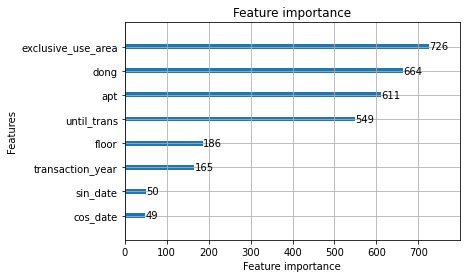

In [ ]:
lgb.plot_importance(lgbm_pickle)

불러온 모델에서는 exclusive_use_area, dong, apt, until_trans가 중요한 변수임을 알 수 있습니다. 

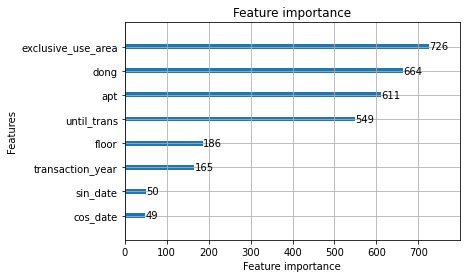

In [ ]:
lgb.plot_importance(best_lgbm_reg)

best_lgbm_reg 모델 또한 불러온 모델과 동일한 변수 중요도를 지니고 있음을 알 수 있습니다. 

## 1.3 Randomness Control
random, numpy 패키지의 난수를 42로 고정하세요.  
더불어서 os 패키지의 난수도 고정해야합니다.  
Permutation 방식의 Feature Importance를 시행한건데, permutation자체에 랜덤성이 있다보니 결과가 재현 가능하도록 시드를 고정해줍니다.  

파이썬의 시드 고정은 R처럼 그냥 set.seed()한다고 해서 고정되지 않습니다. 전체 파이썬과 여러 패키지들의 randomness를 각각 고정해주어야 재현가능해집니다. 정말 귀찮고, 딥러닝의 경우 GPU를 사용할 경우 GPU의 계산과 관련된 시드를 고정하면 속도가 상당히 느려진다고 알려져 있습니다. 더불어서 재현도 100%되진 않으며 성능도 살짝 떨어진다고는 하지만, GPU를 사용하지 않는 경우에는 문제가 없고 최소한 할줄은 알아야겠죠?

더불어서 왜 저런식으로 복잡하게 구성이 되는가?에 대해 궁금할 수 있는데 찾아본 적은 없지만 아마도 numpy는 c++가 뒤에서 연산을 해주는 것으로 알고있고(그래서 빠름!), random은 그냥 파이썬이고, os는 우리 os를 건드리는 것이 아닐까....? 추측입니다 :)

In [ ]:
import random
import os

In [ ]:
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

## 1.4 Permutation Feature Importance
permutation feature importance를 계산하기 위해 best_lgbm_reg를 permutation_importance함수를 사용해 test set에 적합하세요.  
permutation feature importance를 시각화해주세요.  
위의 1.2에서는 train에서 변수중요도를 보고, 지금은 test에서 봐서 좀 이상하다고 생각할수도 있습니다. 편의를 위해, 그리고 실제로 변수중요도에 대한 부분에서 어떤 set에 대해 봐야하는지가 100% 정답처럼 있는 것은 아니라고 알고 있어요.(물론 제가 틀렸을수도!) 아무튼 너무 신경쓰지말고 해주세요!

In [ ]:
from sklearn.inspection import permutation_importance

In [141]:
result = permutation_importance(best_lgbm_reg,test_cbe, test_y,
                                n_repeats=10, random_state=42, n_jobs=2)

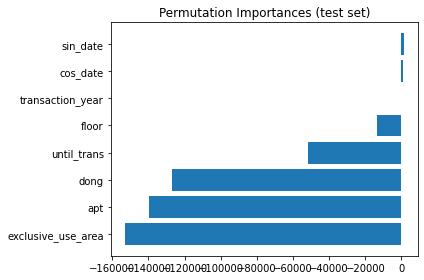

In [148]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(test_cbe.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## 1.5 SHAP(SHapley Additie exPlanations)의 확인과 해석
SHAP Value를 구하고 간단히 해석을 해주세요.  
shap.TreeExplainer, shap_values, shap.summary_plot 정도의 함수만 사용하시면 됩니다.  
결과가 좀 다른건 상관없습니다.

In [ ]:
! pip install shap

In [77]:
import shap

explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)

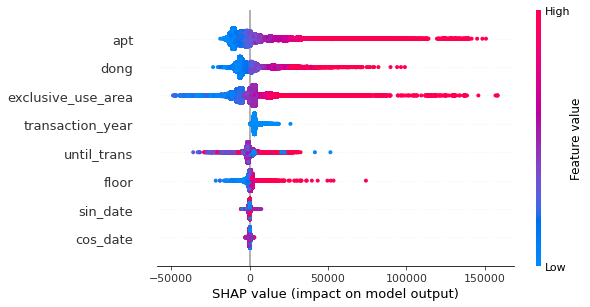

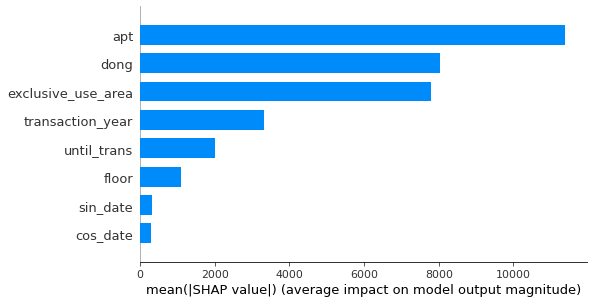

In [97]:
shap.summary_plot(shap_values,test_cbe)
shap.summary_plot(shap_values,test_cbe, plot_type='bar')

apt, dong, exclusive_area가 price예측에 있어 가장 중요한 변수인 걸 알 수 있습니다.  
또한 이 3가지 변수는 price에 양의 영향을 끼치는 것으로 보입니다.  
transaction_year는 이와 반대로 음의 영향을 끼치는 것으로 보입니다.  

# 2. 딥러닝 기본

## 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.

In [150]:
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [151]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [152]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


순차 모델로서 첫번째 레이어는 노드가 256개, 두번째 레이어는 64개, 세번째 레이어는 32개, 네번째 레이어는 1개인 구조입니다.

## 2.2 training loss와 validation loss를 시각화하세요.

In [ ]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

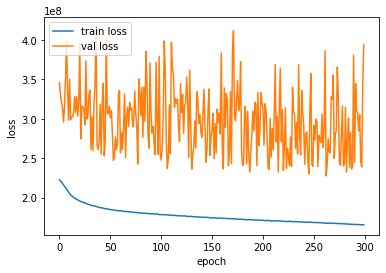

In [214]:
figs, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'],label='train loss')
loss_ax.plot(history.history['val_loss'],label='val loss')

loss_ax.legend(loc='upper left')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

## 2.3 어떤문제가 발생했는지 설명해주세요.

val_loss의 변화가 굉장히 불안정해보입니다.  

## 2.4 더 좋은 성능의 딥러닝 모델을 위해
test set에 대해 딥러닝 모형의 성능을 평가하세요.  
dense 조절, batch_size 조절, regularization, dropout, batch normalization 등의 방법을 활용해 최고의 성능을 얻어보세요.  
만약 성능의 향상이 어렵다면, 다양한 방법들을 시도하는 것을 목표로 해주세요!

In [189]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [192]:
train_cbe.shape

(422164, 8)

In [219]:
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [221]:
model2 = keras.models.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())], kernel_regularizer=keras.regularizers.l1()),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.0001)

model2.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])


history2 = model2.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 1000)

Epoch 1/300
313/313 [==============================] - 8s 19ms/step - loss: 3066158441.1720 - mse: 3066158441.1720 - val_loss: 4171028480.0000 - val_mse: 4171028480.0000
Epoch 2/300
313/313 [==============================] - 6s 18ms/step - loss: 3073840411.7197 - mse: 3073840411.7197 - val_loss: 4171016704.0000 - val_mse: 4171016704.0000
Epoch 3/300
313/313 [==============================] - 6s 18ms/step - loss: 3075144183.8471 - mse: 3075144183.8471 - val_loss: 4170904064.0000 - val_mse: 4170904064.0000
Epoch 4/300
313/313 [==============================] - 6s 18ms/step - loss: 3079157948.3312 - mse: 3079157948.3312 - val_loss: 4171017472.0000 - val_mse: 4171017472.0000
Epoch 5/300
313/313 [==============================] - 6s 18ms/step - loss: 3081027710.3694 - mse: 3081027710.3694 - val_loss: 4171152896.0000 - val_mse: 4171152896.0000
Epoch 6/300
313/313 [==============================] - 6s 18ms/step - loss: 3046787119.2866 - mse: 3046787119.2866 - val_loss: 4170523392.0000 - val_m

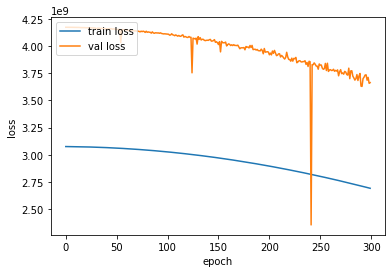

In [222]:
figs, loss_ax = plt.subplots()

loss_ax.plot(history2.history['loss'],label='train loss')
loss_ax.plot(history2.history['val_loss'],label='val loss')

loss_ax.legend(loc='upper left')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

In [224]:
model.evaluate(test_cbe, test_y, batch_size=512)

179/179 [==============================] - 1s 3ms/step - loss: 3080919552.0000 - mse: 3080919552.0000


[3080919552.0, 3080919552.0]

In [223]:
model2.evaluate(test_cbe, test_y, batch_size=1000)

92/92 [==============================] - 1s 4ms/step - loss: 19520170.0000 - mse: 19520154.0000


[19520170.0, 19520154.0]